# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


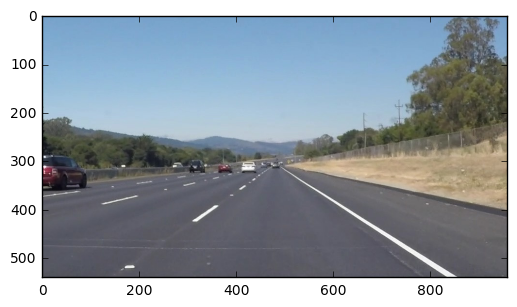

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_canny(img, sigma):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (0.9 + sigma) * v))
    return cv2.Canny(img, lower, upper)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

from functools import reduce

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    def slope(x1,y1,x2,y2):
        return ((y2-y1)/(x2-x1))
    
    lines_0 = [l for l in lines 
                 for (x1,y1,x2,y2) in l
                 if slope(x1,y1,x2,y2) < 0]
    lines_1 = [l for l in lines 
                 for (x1,y1,x2,y2) in l
                 if slope(x1,y1,x2,y2) >= 0]
    slopes_0 = list(map(lambda l: slope(*l.T), lines_0))
    slopes_1 = list(map(lambda l: slope(*l.T), lines_1))
    
    unfiltered_0 = zip(lines_0, slopes_0)
    unfiltered_1 = zip(lines_1, slopes_1)
    
    std_0 = np.std(slopes_0)
    mu_0  = np.mean(slopes_0)
    filtered_0 = [(l,m) for (l,m) in unfiltered_0 if abs(m) < 1.10 and abs(m) > 0.4]
    can_draw_line_0 = len(filtered_0) > 0
    if not can_draw_line_0:
        print("ERROR: no lines for group 0")
        print("Unfiltered lines and slopes " + str(list(zip(lines_0, slopes_0))))
    std_1 = np.std(slopes_1)
    mu_1  = np.mean(slopes_1)
    filtered_1 = [(l,m) for (l,m) in unfiltered_1 if abs(m) < 1.10 and abs(m) > 0.4]
    can_draw_line_1 = len(filtered_1) > 0
    if not can_draw_line_1:
        print("ERROR: no lines for group 1")
        print("Unfiltered lines and slopes " + str(list(zip(lines_1, slopes_1))))

    def xs(l):
        (x1,y1,x2,y2) = l
        return (x1,x2)
    def ys(l):
        (x1,y1,x2,y2) = l
        return (y1,y2)

    def avg_xs(lines):
        return reduce(lambda cur,xtup: cur+xtup[0]+xtup[1], map(lambda l: xs(*l), lines),0)/(2*len(lines))
    def avg_ys(lines):
        return reduce(lambda cur,ytup: cur+ytup[0]+ytup[1], map(lambda l: ys(*l), lines),0)/(2*len(lines))
        
    if can_draw_line_0:
        lines_0, slopes_0 = (list(t) for t in zip(*filtered_0))
        avg_x0 = avg_xs(lines_0)
        avg_y0 = avg_ys(lines_0)
        min_y0 = reduce(lambda cur,ys: min(cur,ys[0],ys[1]), map(lambda l: ys(*l), lines_0),10000)
        m0 = np.median(slopes_0)
        y00 = img.shape[0]
        x00 = (y00 - avg_y0)/m0 + avg_x0
        y01 = min_y0
        x01 = (y01 - avg_y0)/m0 + avg_x0
        cv2.line(img, (int(x00),int(y00)), (int(x01),int(y01)), color, thickness)
    if can_draw_line_1:
        lines_1, slopes_1 = (list(t) for t in zip(*filtered_1))
        avg_x1 = avg_xs(lines_1)
        avg_y1 = avg_ys(lines_1)
        min_y1 = reduce(lambda cur,ys: min(cur,ys[0],ys[1]), map(lambda l: ys(*l), lines_1),10000)
        m1 = np.median(slopes_1)
        y10 = img.shape[0]
        x10 = (y10 - avg_y1)/m1 + avg_x1
        y11 = min_y1
        x11 = (y11 - avg_y1)/m1 + avg_x1
        cv2.line(img, (int(x10),int(y10)), (int(x11),int(y11)), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
# Pipeline that image baby

# hyperparameters
low_canny = 40
high_canny = 120
kernel_size = 5
rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 80
max_line_gap = 50

def pipeline(image):
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.05,imshape[0]),
                          (imshape[1]*0.45,imshape[0]*0.6),
                          (imshape[1]*0.55,imshape[0]*0.6),
                          (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
    canny_image  = auto_canny(gaussian_blur(grayscale(image), kernel_size), 0.33)#, low_canny, high_canny)
    masked_image = region_of_interest(canny_image, vertices)
    return weighted_img(hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap), 
                 image, α=0.8, β=1., λ=0.)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

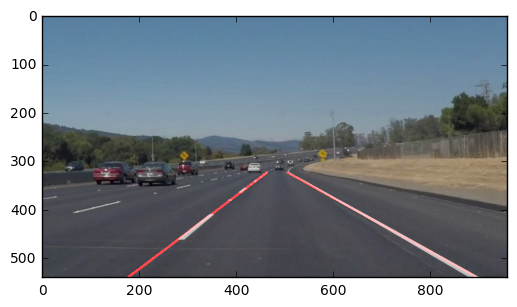

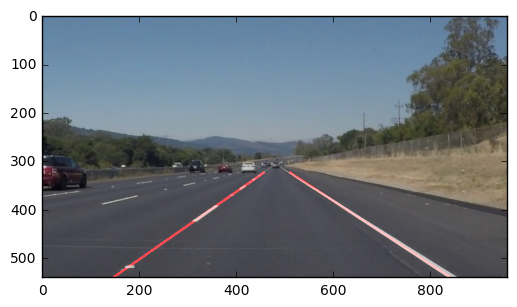

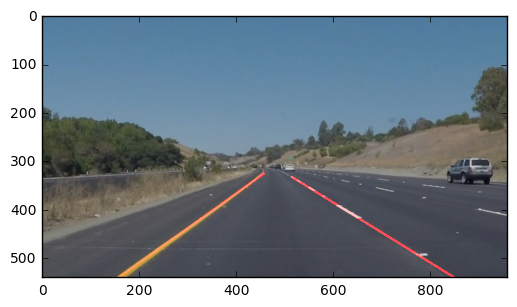

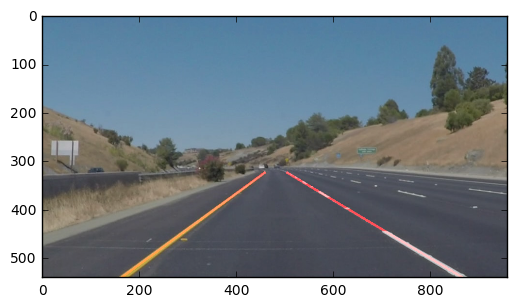

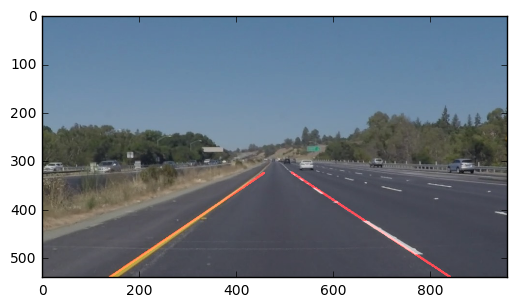

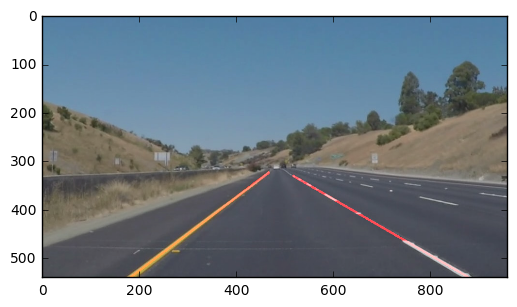

In [5]:
import os

def test_on_imdir(imdir):
    for image in os.listdir(imdir):
        plt.figure()
        plt.imshow(pipeline(mpimg.imread(imdir + image)))

test_on_imdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML, YouTubeVideo

In [7]:
def process_image(image):
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 52.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.18 s, sys: 530 ms, total: 3.71 s
Wall time: 4.67 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:11<00:00, 57.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.84 s, sys: 1.17 s, total: 11 s
Wall time: 12.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Student Reflections

Ah, old school computer vision. So sexy, so suave. 

I was familiar with the technique of Canny edge detection before this project, but this was my introduction to the Hough transform and its applications. Both are exemplary engineering tools: compressing concepts down into the language of mathematics. When I first learned about Canny edge detection, I had that familiar, "Aha!" moment. After hearing the definition, you can't think of the concept "edge" the same anymore. Now edges are "sharp changes in light intensity". 

One thing I think would be a _hit_ with students is an interactive demo as shown in the following video. I couldn't find a demo online with a modern feel / UX -- best was probably http://liquify.eu/project/HoughTransform/. I'd be happy to takckle this as a pet project and share my results with the instructors!

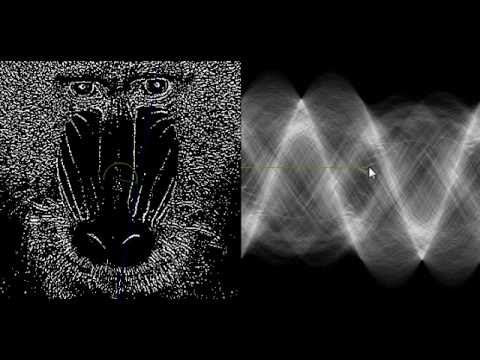

In [12]:
YouTubeVideo("ebfi7qOFLuo")

Now I will address the specific questions. 

> How could you imagine making your algorithm better / more robust? Where will your current algorithm be likely to fail?

Let me walk you through the iterations of my solution. After fiddling with the utility functions, I set up my pipeline using the parameters suggested by the last quiz of the lesson. I tweaked these a few times, observing changes in behavior on the example videos. When I was happy with the results on the first two videos, I moved onto making the lane line prediction.

I decided to start with a very simple statistical model for the lane predictions. The line segments detected with the Hough transform were grouped by their slope, discriminating by sign. Then I constructed each line through the center of mass of and with the mean slope of the respective collection of line segments. The "top" of the line (as seen by the viewer) is at the _minimum_ $y$ value for the set of line segments.

The first thing I noticed about the result was that the line was noisy over time, seeming somewhat unstable. In some cases, it was evident that an atypical line segment was disturbing the mean slope. So I did two things to stabilize the model: I used the median slope as the estimator and filtered out all but "reasonable" slopes, which I defined to be the range $(0.4, 1.10)$. The resulting model was much better.

At this point I ran my transformation on the challenge. Crash. Burn. Lawsuit. I hadn't considered the case when filtering the detected line segments yields the empty set. I updated the code so it would carry on if it couldn't draw a line, but report a warning in those cases and list the unfiltered line segments and their slopes. The resulting video is still not perfect. I realized one of the issues was that the threshold for "edge-ness" was constant throughout the video. I decied to try using an adaptive version of Canny edge detection [1]. I think the results are better. I tweaked the example in the reference to be asymmetric with the low- and high-thresholding.

I'm happy with state of the project given the total time invested, and I am confident I can significantly improve the model. One idea that comes to mind is increasing the set of detected lines by using multiple variants of edge detection.

Another thing comes to mind: we are discarding so much information! Specifically, we disregard temporal correlations between images and instead construct the line for each video in isolation. When I interned at JPL, I was introduced to the Kalman filter, in the context of error analysis of an inertial measurement unit. I have not used it since then, but I suspect some variant of it could be applied to wrap around our sequence of state estimations $(Image_t, Line(Image_t))$ to smooth our result and compensate for when we don't have any reliable signal at a given time $t$.

My algorithm would certainly have problems off the highway or in situations where the lane disappears for a period of time (this even disorients me sometimes when it happens on wide highways). I also am concerned by my restrictions on lane angle overfitting on the examples: steeper highway will probably cause problems. I also haven't tested it in various weather and lighting conditions. It would be interesting to see the performance at night with only the car's headlamps.


[1] http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  2%|▏         | 4/251 [00:00<00:06, 38.10it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[662, 667, 858, 670]], dtype=int32), array([ 0.01530612])), (array([[ 950,  677, 1086,  677]], dtype=int32), array([ 0.]))]


 14%|█▍        | 35/251 [00:00<00:05, 39.70it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[652, 666, 876, 670]], dtype=int32), array([ 0.01785714])), (array([[ 975,  676, 1084,  676]], dtype=int32), array([ 0.])), (array([[1006,  713, 1113,  717]], dtype=int32), array([ 0.03738318])), (array([[701, 666, 838, 668]], dtype=int32), array([ 0.01459854]))]


 41%|████      | 103/251 [00:03<00:04, 29.77it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[852, 671, 969, 677]], dtype=int32), array([ 0.05128205])), (array([[168, 678, 265, 683]], dtype=int32), array([ 0.05154639])), (array([[415, 599, 536, 599]], dtype=int32), array([ 0.])), (array([[362, 552, 509, 575]], dtype=int32), array([ 0.15646259])), (array([[503, 530, 644, 545]], dtype=int32), array([ 0.10638298])), (array([[376, 659, 471, 661]], dtype=int32), array([ 0.02105263])), (array([[364, 570, 473, 586]], dtype=int32), array([ 0.14678899])), (array([[249, 677, 341, 677]], dtype=int32), array([ 0.])), (array([[249, 663, 357, 663]], dtype=int32), array([ 0.])), (array([[455, 560, 542, 563]], dtype=int32), array([ 0.03448276])), (array([[362, 557, 531, 583]], dtype=int32), array([ 0.15384615])), (array([[154, 676, 280, 683]], dtype=int32), array([ 0.05555556])), (array([[441, 547, 560, 553]], dtype=int32), array([ 0.05042017])), (array([[300, 587, 437, 616]], dtype=int32), array([ 0.21167883])), (array([[400, 5

 44%|████▍     | 111/251 [00:03<00:04, 29.75it/s]

ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[656, 668, 977, 588]], dtype=int32), array([-0.24922118])), (array([[713, 653, 980, 587]], dtype=int32), array([-0.24719101])), (array([[510, 469, 621, 435]], dtype=int32), array([-0.30630631])), (array([[599, 442, 719, 440]], dtype=int32), array([-0.01666667])), (array([[646, 668, 729, 648]], dtype=int32), array([-0.24096386])), (array([[759, 597, 842, 592]], dtype=int32), array([-0.06024096]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[ 863,  670, 1030,  615]], dtype=int32), array([-0.32934132])), (array([[513, 467, 621, 434]], dtype=int32), array([-0.30555556])), (array([[ 930,  649, 1010,  623]], dtype=int32), array([-0.325])), (array([[576, 434, 663, 433]], dtype=int32), array([-0.01149425]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[526, 462, 625, 434]], dtype=int32), array([-0.28282828]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[589, 442, 71

 47%|████▋     | 119/251 [00:03<00:04, 28.60it/s]

ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[577, 439, 695, 437]], dtype=int32), array([-0.01694915]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[643, 446, 724, 443]], dtype=int32), array([-0.03703704])), (array([[518, 465, 625, 432]], dtype=int32), array([-0.30841121])), (array([[587, 446, 726, 444]], dtype=int32), array([-0.01438849]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[608, 445, 724, 443]], dtype=int32), array([-0.01724138])), (array([[517, 465, 619, 432]], dtype=int32), array([-0.32352941])), (array([[574, 447, 685, 445]], dtype=int32), array([-0.01801802]))]
ERROR: no lines for group 1
Unfiltered lines and slopes []
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[573, 451, 731, 448]], dtype=int32), array([-0.01898734])), (array([[501, 474, 621, 435]], dtype=int32), array([-0.325]))]
ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[615, 449, 722, 451]], dtype=int32), arra

 50%|█████     | 126/251 [00:03<00:04, 28.15it/s]

ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[562, 452, 735, 449]], dtype=int32), array([-0.01734104]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[555, 450, 645, 449]], dtype=int32), array([-0.01111111])), (array([[529, 458, 609, 432]], dtype=int32), array([-0.325]))]
ERROR: no lines for group 0
Unfiltered lines and slopes []
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[543, 453, 735, 449]], dtype=int32), array([-0.02083333]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[261, 685, 404, 680]], dtype=int32), array([-0.03496503])), (array([[537, 454, 669, 451]], dtype=int32), array([-0.02272727])), (array([[239, 685, 412, 679]], dtype=int32), array([-0.03468208])), (array([[408, 679, 489, 670]], dtype=int32), array([-0.11111111]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[536, 455, 627, 454]], dtype=int32), array([-0.01098901])), (array([[413, 679, 513, 672]], dtype=int32), arra

 51%|█████▏    | 129/251 [00:04<00:04, 25.93it/s]

ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[452, 674, 643, 667]], dtype=int32), array([-0.03664921])), (array([[266, 685, 407, 680]], dtype=int32), array([-0.03546099])), (array([[567, 456, 659, 432]], dtype=int32), array([-0.26086957])), (array([[480, 672, 569, 669]], dtype=int32), array([-0.03370787])), (array([[575, 456, 660, 432]], dtype=int32), array([-0.28235294]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[256, 686, 404, 681]], dtype=int32), array([-0.03378378])), (array([[436, 676, 534, 671]], dtype=int32), array([-0.05102041])), (array([[238, 686, 411, 680]], dtype=int32), array([-0.03468208])), (array([[229, 686, 326, 669]], dtype=int32), array([-0.17525773])), (array([[235, 686, 349, 662]], dtype=int32), array([-0.21052632])), (array([[650, 459, 734, 449]], dtype=int32), array([-0.11904762]))]
ERROR: no lines for group 0
Unfiltered lines and slopes [(array([[449, 675, 659, 668]], dtype=int32), array([-0.03333333])), (array([[227,

 65%|██████▍   | 162/251 [00:05<00:03, 26.14it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[660, 665, 858, 668]], dtype=int32), array([ 0.01515152])), (array([[ 941,  675, 1137,  675]], dtype=int32), array([ 0.])), (array([[522, 689, 660, 699]], dtype=int32), array([ 0.07246377])), (array([[287, 594, 480, 598]], dtype=int32), array([ 0.02072539])), (array([[288, 596, 478, 600]], dtype=int32), array([ 0.02105263])), (array([[290, 593, 480, 597]], dtype=int32), array([ 0.02105263])), (array([[1095,  715, 1204,  719]], dtype=int32), array([ 0.03669725])), (array([[1115,  713, 1205,  715]], dtype=int32), array([ 0.02222222])), (array([[841, 544, 925, 556]], dtype=int32), array([ 0.14285714])), (array([[1113,  712, 1200,  712]], dtype=int32), array([ 0.])), (array([[410, 527, 521, 527]], dtype=int32), array([ 0.])), (array([[1097,  715, 1184,  715]], dtype=int32), array([ 0.])), (array([[395, 539, 510, 561]], dtype=int32), array([ 0.19130435]))]


 73%|███████▎  | 184/251 [00:06<00:02, 24.04it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[610, 667, 781, 667]], dtype=int32), array([ 0.])), (array([[ 949,  676, 1089,  676]], dtype=int32), array([ 0.])), (array([[846, 669, 926, 675]], dtype=int32), array([ 0.075])), (array([[ 998,  677, 1079,  677]], dtype=int32), array([ 0.]))]


 92%|█████████▏| 231/251 [00:07<00:00, 28.82it/s]

ERROR: no lines for group 1
Unfiltered lines and slopes [(array([[605, 668, 780, 668]], dtype=int32), array([ 0.])), (array([[810, 669, 968, 677]], dtype=int32), array([ 0.05063291])), (array([[ 957,  677, 1088,  677]], dtype=int32), array([ 0.]))]


100%|██████████| 251/251 [00:08<00:00, 29.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.35 s, sys: 540 ms, total: 6.89 s
Wall time: 9.62 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))